In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 80
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
korean_script_list = list()
jamo_script_list = list()

jamo_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = jamotools.split_syllables(line, 'JAMO')
        jamo_filtered = ''.join(jamo_regex.findall(jamo))
        jamo_script_list.append(jamo_filtered)

In [9]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(32)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                lev_truth_list = batch[4]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [10]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [11]:
unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('A'), ord('Z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('a'), ord('z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('0'), ord('9') + 1):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
                      '-', '<s>', '</s>']
unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [12]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [13]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [14]:
batch_size = 16
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [15]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [16]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [17]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [18]:
# def label_to_string(labels):
#     if len(labels.shape) == 1:
#         sent = str()
#         for i in labels:
#             if i.item() == EOS_token:
#                 break
#             sent += index2char[i.item()]
#         return sent

#     elif len(labels.shape) == 2:
#         sents = list()
#         for i in labels:
#             sent = str()
#             for j in i:
#                 if j.item() == EOS_token:
#                     break
#                 sent += index2char[j.item()]
#             sents.append(sent)

#         return sents
    
def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

# def get_distance(ref_labels, hyp_labels, display=False):
#     total_dist = 0
#     total_length = 0
#     for i in range(len(ref_labels)):
#         ref = label_to_string(ref_labels[i])
#         hyp = label_to_string(hyp_labels[i])
#         dist, length = char_distance(ref, hyp)
#         total_dist += dist
#         total_length += length 
#         if display:
#             cer = total_dist / total_length
#             print('%d (%0.4f)\n(%s)\n(%s)' % (i, cer, ref, hyp))
#     return total_dist, total_length

In [19]:
# def c2i_decoding(c2i, sentence):
#     tokens = list()
#     for char in sentence:
#         try:
#             tokens.append(c2i[char])   
#         except:
# #             print(char)
#             pass
#     return tokens

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list

No CER Record
Loading NSML_2nd Error
09-20 08:59:14
09-20 09:03:21
Mean Train Loss: 0.08649717292617694
Train CER: 0.9063092167842992
09-20 09:03:34
Mean Evaluation Loss: 0.07237562650692708
Evaluation CER: 0.8599603373504479


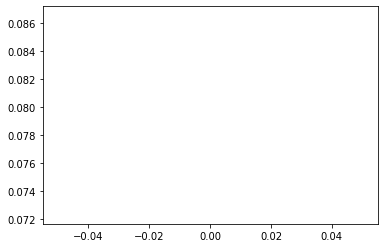

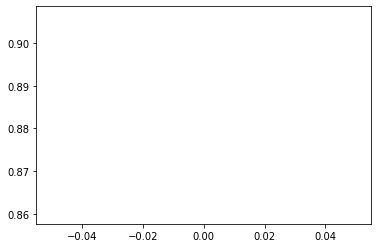

<s><s><s><s>ᄋ___________________________________________________________________________________________ᆫ나ᅡ요??</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s>
<s>ᄋᆫ나요?</s>
<s>브레이크 타임 있나요?</s>___________


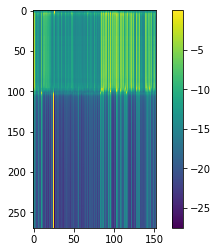

<s><s><s>ᄋ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆫ나ᅡ요?</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

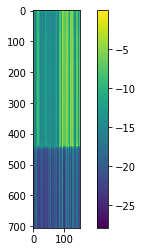

-------------------------------------------------------------------------------------------------------
09-20 09:03:35
09-20 09:07:45
Mean Train Loss: 0.07336166217772597
Train CER: 0.9253943512687823
09-20 09:07:59
Mean Evaluation Loss: 0.06950502887857186
Evaluation CER: 0.8627497984178526


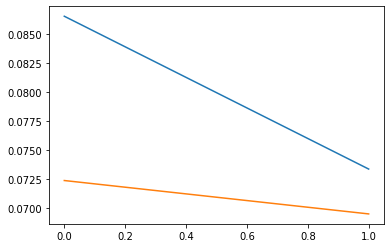

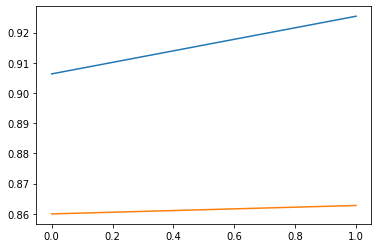

<s><s><s>아_________________________________________________________________________________________________________________________________________________________________________________________________ᅡ_ᄋ_______________________________________________________________________________________________________________________________??_______</s></s></s>__________________________________________________________________________
<s>아ᅡᄋ?</s>
<s>아닙니다. 그럼 치즈케익 메뉴도 추가 주문하고 싶습니다. 그리고 제가 직접 방문해서 받을께요.</s>____


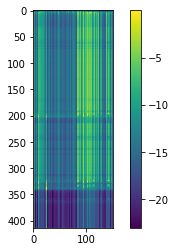

<s><s><s><s>아__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆻ나요?</s></s>__________________________________________________________________________________________________________________________________________________________________________________
<s>았나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


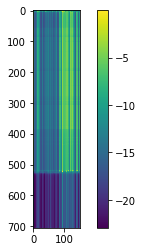

-------------------------------------------------------------------------------------------------------
09-20 09:08:00
09-20 09:12:09
Mean Train Loss: 0.0682013601947076
Train CER: 0.8581703703148912
09-20 09:12:23
Mean Evaluation Loss: 0.06684109254664246
Evaluation CER: 0.8425697910083466


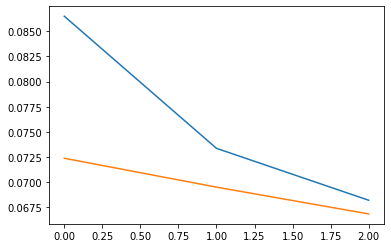

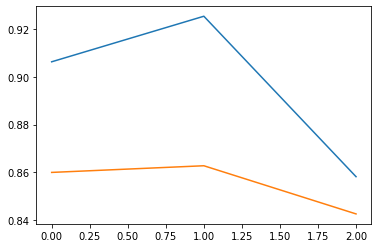

<s><s><s>아ᄋ____________________________________________________________________________________________ᅡ___________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆫ나요?</s></s>____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<s>아아ᅵᆫ나요?</s>
<s>춘해병원 쪽이구요. 춘해병원으로 오셔서 이 번호로 전화주시면 음식 받으러 내려가겠습니다.</s>__


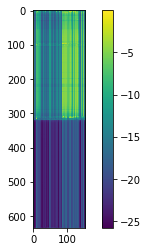

<s><s><s>아ᄋ_____________________________________________________________________________________________________________________________________________가_______________________________________________________________________________________________________________________________________가____________________________________________________________________________________________________________________인나요?</s></s>______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
<s>아ᄋ가가인나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


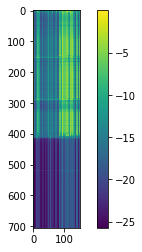

-------------------------------------------------------------------------------------------------------
09-20 09:12:24
09-20 09:16:33
Mean Train Loss: 0.07550428818881773
Train CER: 0.8798665599545227
09-20 09:16:46
Mean Evaluation Loss: 0.07167937192935254
Evaluation CER: 0.8625536644365507


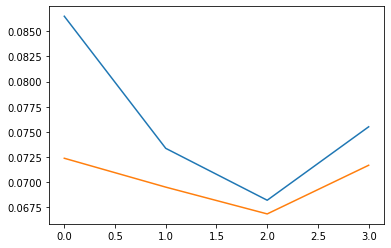

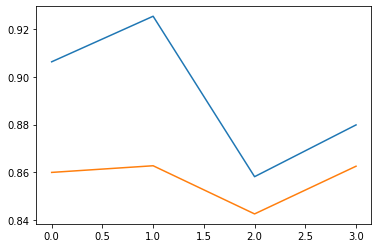

<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>_______________________________________________________________________________________________________________________________________________________________________ᆻ나요ᅭ?</s>
<s>ᆻ나요?</s>
<s>인터넷 예약은 어떻게 하는거죠?</s>_________


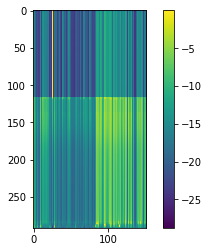

<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

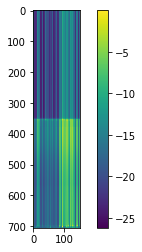

-------------------------------------------------------------------------------------------------------
09-20 09:16:47
09-20 09:20:57
Mean Train Loss: 0.06845507940091229
Train CER: 0.8569489055102586
09-20 09:21:10
Mean Evaluation Loss: 0.06671636139560998
Evaluation CER: 0.8529866846819361


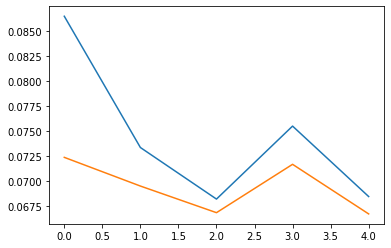

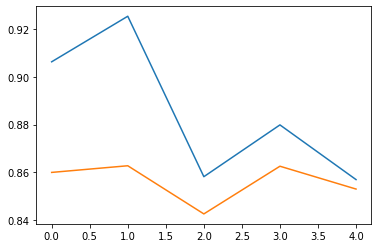

<s>아___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

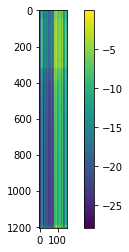

<s>아_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆫ나요?</s>
<s>아ᅵᆫ나요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


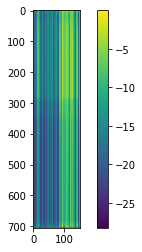

-------------------------------------------------------------------------------------------------------
09-20 09:21:11
09-20 09:25:20
Mean Train Loss: 0.06609487934043
Train CER: 0.8440760789540017
09-20 09:25:33
Mean Evaluation Loss: 0.06557057886907397
Evaluation CER: 0.8426133763375248


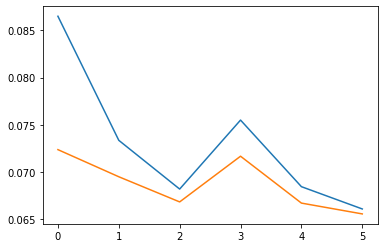

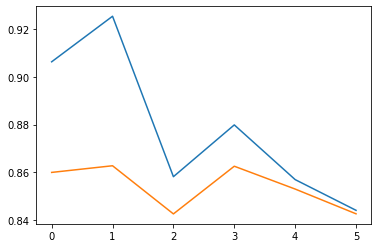

<s>아__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 안나요?</s>
<s>아 안나요?</s>
<s>오늘 런치 시간이 언제인가요?</s>_


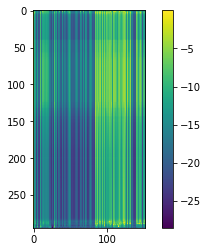

<s>아_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 안나요?</s>
<s>아 안나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


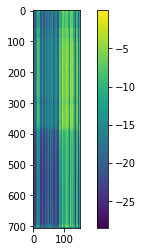

-------------------------------------------------------------------------------------------------------
09-20 09:25:34
09-20 09:29:42
Mean Train Loss: 0.0653220271009233
Train CER: 0.8452233018430075
09-20 09:29:56
Mean Evaluation Loss: 0.0652056213892208
Evaluation CER: 0.8444657528275983


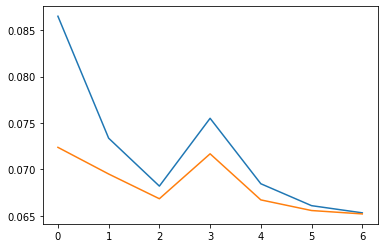

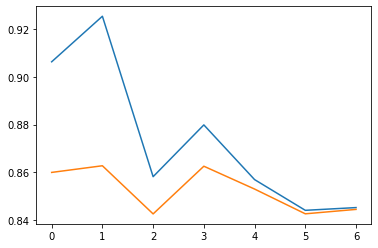

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>아ᄋ 인나요?</s>
<s>아웃백 스페셜 서로인 하나요.</s>__


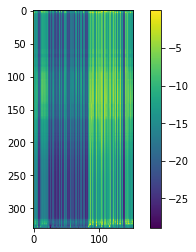

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>아ᄋ 인나요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


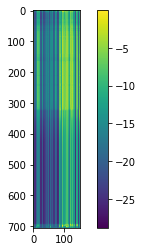

-------------------------------------------------------------------------------------------------------
09-20 09:29:57
09-20 09:34:05
Mean Train Loss: 0.06456618760727388
Train CER: 0.8473290430596976
09-20 09:34:18
Mean Evaluation Loss: 0.06458320462035327
Evaluation CER: 0.843746594896158


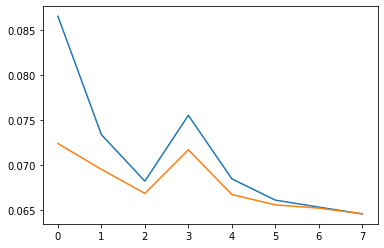

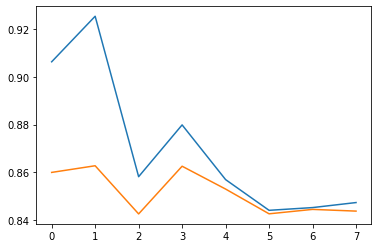

<s>아ᄋ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 한나요?</s>
<s>아ᄋ 한나요?</s>
<s>제가 아직 초보 운전이라서 지금 저녁 시간이라 사람 많을텐데  출구 공간이 넓은가요?</s>__________


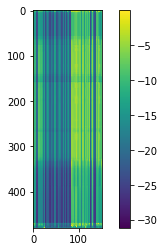

<s>아ᄋ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아ᄋ 있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


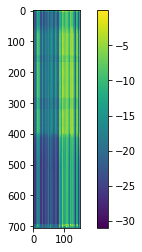

-------------------------------------------------------------------------------------------------------
09-20 09:34:19
09-20 09:38:30
Mean Train Loss: 0.0628287573394386
Train CER: 0.8409468448911993
09-20 09:38:44
Mean Evaluation Loss: 0.059410207800090896
Evaluation CER: 0.8263560485540568


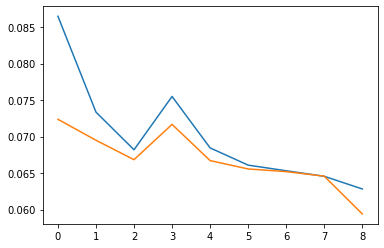

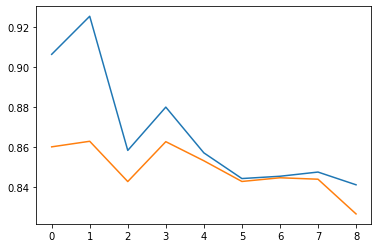

<s>안____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 인나요?</s>
<s>안 인나요?</s>
<s>예약 가능 시간은 언제인가요?</s>


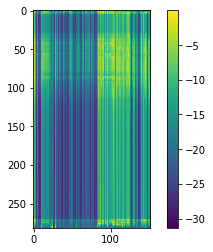

<s>안__________________________________________________________________________________________ _________________________________________________________________________________________________________________________________________________________________________ _______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 힌나요?</s>
<s>안   힌나요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


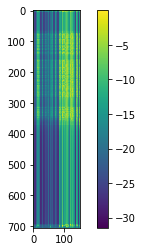

-------------------------------------------------------------------------------------------------------
09-20 09:38:45
09-20 09:42:55
Mean Train Loss: 0.05520900820662822
Train CER: 0.7987152408486501
09-20 09:43:08
Mean Evaluation Loss: 0.04925540808160924
Evaluation CER: 0.7822041100965414


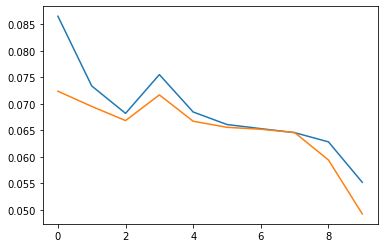

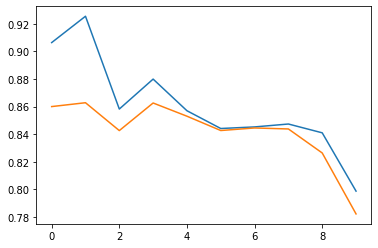

<s>아___________________________________________________________________________가_______________________________________ᅡ___ᄋ__________ᅮ_______가__________지___ᄋ__________어___ᄋ___가________ᄌ____서____모__ᄋ_____으__ᄋ_______시____고___야__________________________지_________추_____ᅥ____ᅥ___________시__오________야_____ 주___주___구____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

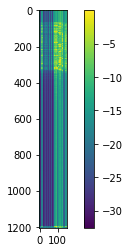

<s>아__________________________________치______아____ᅡ____아___ 시___시____ᅵ___채___ᄋ_________가_________아_____ᅳ__채____으____가_____에______ᅡ___에_________거________거____ᅮ___가____에_____이____사_______치____오_____가_____에____개___에________ 시______ᅥ_____거___제____________가______________ 가________아___아____으___가_____ᄉᄉ_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이_시요?</s>
<s>아치아ᅡ아 시시ᅵ채ᄋ가아ᅳ채으가에ᅡ에거거ᅮ가에이사치오가에개에 시ᅥ거제가 가아아으가ᄉ이시요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


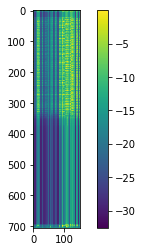

-------------------------------------------------------------------------------------------------------
09-20 09:43:09
09-20 09:47:20
Mean Train Loss: 0.047725562945379905
Train CER: 0.7661671294169347
09-20 09:47:34
Mean Evaluation Loss: 0.04346204551707361
Evaluation CER: 0.7448732756554144


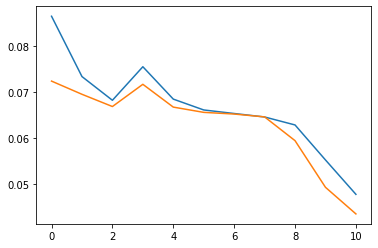

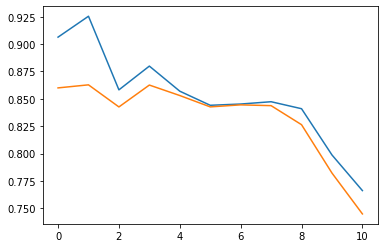

<s>아________________________________________며___ᄋ_____시______여_______어_____시_____가_____가______자_____이___이__메________________________ᅡ_____치____가_____바_____무______므______마___ᄋ______________ _지___ᅡ_________토___데__  가___라______느__ 자_________거__ 수____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅦ요?</s>
<s>아며ᄋ시여어시가가자이이메ᅡ치가바무므마ᄋ 지ᅡ토데 가라느 자거 수ᅦ요?</s>
<s>안녕하세요.  지금 근처인데 찾지 못하고 있는데 여기서 어떻게 가야하는지 알고 싶은데요.</s>______


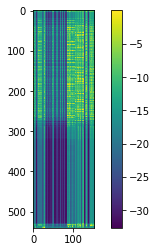

<s>아______________________________________________________________처_______________ᅥ____시_______데____ᄋ_____ᄋ____ᄋ_____시________________________________________________가___________데_____시_____  자________하________아_________ᅩ_____마______지______구___처_____지________ᅡ_________________________________________________ᅵ_____지____자________가___ᄋ___________ᅥ______가_______조____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아처ᅥ시데ᄋᄋᄋ시가데시 자하아ᅩ마지구처지ᅡᅵ지자가어가조 있나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


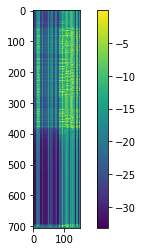

-------------------------------------------------------------------------------------------------------
09-20 09:47:35
09-20 09:51:46
Mean Train Loss: 0.04330022894991122
Train CER: 0.7324365058605184
09-20 09:51:59
Mean Evaluation Loss: 0.03999054382266833
Evaluation CER: 0.7117048401508053


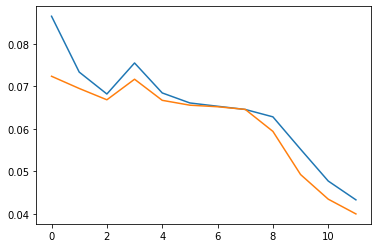

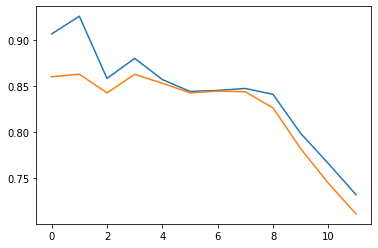

<s>이____________________________________야_____시___이___ᄋ____야_______오____가___으_____노____  이__여_____ᅮ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이_나요?</s>
<s>이야시이ᄋ야오가으노 이여ᅮ이나요?</s>
<s>이번 주에 예약 못하는 요일이 언젠가요?</s>_


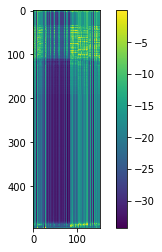

<s>아_________________________ᄅ____ᆫ__추_______ᅡ__________아___ 스____ᅦ___이___데____ᄋ__라____고_____은_모________데____느_ᆫ__바____ᄂ느_____데______________거________포_______바_____메_____이___자_____ᆫ _주____므__ᆫ__모_____네__ 드_____________ 시______고_____보___에______테__ _하____이_______ 하____느___가___가____느__ 마___ᆯ 수___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅦ죠.</s>
<s>아ᄅᆫ추ᅡ아 스ᅦ이데ᄋ라고은모데는바느데거포바메이잔 주믄모네 드 시고보에테 하이 하느가가느 말 수ᅦ죠.</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


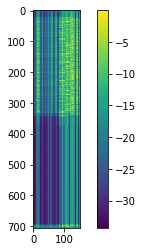

-------------------------------------------------------------------------------------------------------
09-20 09:52:00
09-20 09:56:13
Mean Train Loss: 0.04049227217572199
Train CER: 0.7013203627501897
09-20 09:56:27
Mean Evaluation Loss: 0.03761326803049363
Evaluation CER: 0.6793645259005818


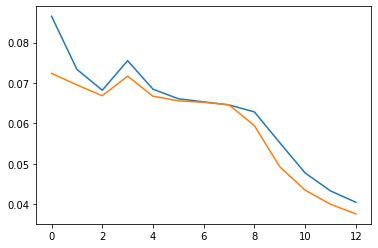

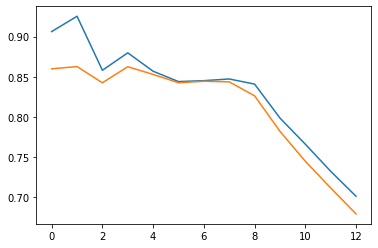

<s>아___________________________________________________________가______이___ᆫ____________________즈_________마_____ 가_____그______니_______________________________________________ _ᅵ______ᅩ________________세______ 수_________하_____ᅵ__ᅵ___다_____ᅭ_________________________________ 어________시_______게___여____하__흐______ᅳ___ᆫ___자____하_____________________________________________________________________________________________________________________________________________________ 있나요?</s>
<s>아가인즈마 가그니 ᅵᅩ세 수하ᅵᅵ다ᅭ 어시게여하흐ᅳᆫ자하 있나요?</s>
<s>연말인데 행사 같은 게 있나요? 크리스마스 때 행사 있나요? 봄 시즌에 하는 행사가 있나요?</s>______


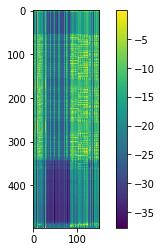

<s>애______________________________________________________________녀______________________ 사_____________지___이_________ᆨ_으___________ 자______ᅳ_______드___________________시______________________ _이___________이_____즈_____ᄂ느_____지___하____가______ᅧ_____사____료________________________________________ ᄋ_____ᄋ______________으_____져____ᅩ__ᅮ__드___다_____수_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵᆸ니다.</s>
<s>애녀 사지익으 자ᅳ드시 이이즈느지하가ᅧ사료 ᄋᄋ으져ᅩᅮ드다수ᅵᆸ니다.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


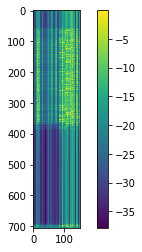

-------------------------------------------------------------------------------------------------------
09-20 09:56:28
09-20 10:00:39
Mean Train Loss: 0.03833431584287292
Train CER: 0.6739698602849219
09-20 10:00:52
Mean Evaluation Loss: 0.035585148419378064
Evaluation CER: 0.6483753568548827


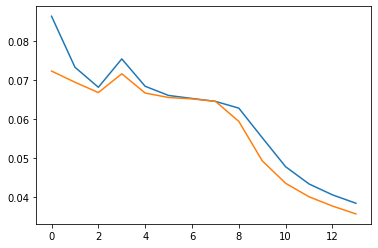

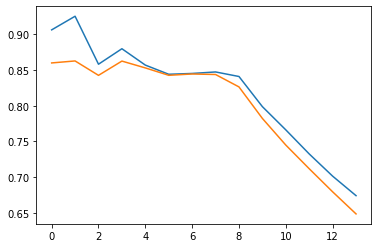

<s>아_____________________________________________이__기______카____차______치___가___이__ 가______는__데____________________________ _재_____그__데____즈__나________ᅮ____ᅩ__하_____이____그____ 가_____그____가___는ᆫ__2___고___ _가___이____나______________________________________  ᄌ__  저_________하_______________________________________________________________________________________________________________________________________________________________________________________________________________아요?</s>
<s>아이기카차치가이 가는데 재그데즈나ᅮᅩ하이그 가그가는2고 가이나 ᄌ 저하아요?</s>
<s>아이들이랑 같이 가려고하는데 키즈메뉴말고 아이들이 먹을만한게 뭐가있나요? 추천 부탁해요.</s>___


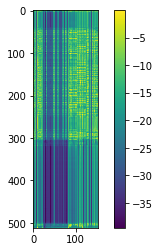

<s>아______________________________ᄅ___ᆫ___츠_______가______스_____케____ᄋ_____브____ᄒ____구_________거_____즈_ 드____그___느_____데__________________________________ 거____ᅩ_____ 거____으___이_ 사_______주____모_____거____으___드________________ _주___가____가___즈______파___ᅡ__지___  가____느_____하__ᅳ__하_ᆯ 즈___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᆸᄁᄌ죠?</s>
<s>아ᄅᆫ츠가스케ᄋ브ᄒ구거즈 드그느데 거ᅩ 거으이 사주모거으드 주가가즈파ᅡ지 가느하ᅳ할 즙ᄁ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


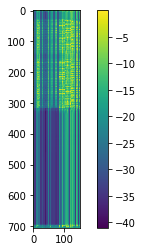

-------------------------------------------------------------------------------------------------------
09-20 10:00:53


In [ ]:
EPOCH = 12 * 6     
           
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512, len(unicode_jamo_list), device)

net_optimizer = optim.Adam(net.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss().to(device)

keyword = 'NSML_2nd'

train_loss_history = list()
eval_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history{}.npy'.format(keyword)))
except:
    print("No CER Record")

try:
    load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Error".format(keyword))


for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()

    total_dist = 0
    total_length = 0
#     count = 0
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth_list = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
#             print("Loss: {}".format(loss))
#             count += 1
#             print("Train {}/{}".format(count, int(np.ceil(len(wav_path_list_train)/batch_size))))
#             # logger.info("Training")

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Train CER: {}".format(train_cer))
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list, lev_truth_list_ = batch
            pred_tensor_, loss = evaluate(net, ctc_loss, tensor_input.to(device), ground_truth_.to(device),
                                          loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor_, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list_, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Evaluation CER: {}".format(eval_cer))
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    #####
    
    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    np.save('model_saved/train_cer_history{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)
    plt.show()
    
    plt.figure()
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()

    # index is the position of the max probility of the first batch
    # Shape of the pred_tensor: (T, B, 75)
    # Shape of the index: (T)
    _, index = pred_tensor[:, 0, :].max(-1)

    # Change index numbers to character
    sentence = tokenizer.num2word(index.view(-1))

    # Change list to string
    print(''.join(sentence))

    # Remove "blank" and overlapping characters
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))

    true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    # Plot image
    # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
    plt.figure()
    plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

    _, index = pred_tensor_[:, 0, :].max(-1)

    sentence = tokenizer.num2word(index.view(-1))
    print(''.join(sentence))
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))
    true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    plt.figure()
    plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    